# Alzheimer's Disease Classification from MRI Scans
### Author - Satrajit Kar, MESE @ JU'25 (26/05/2025)
### Let's Hope for the Best, Prepare for the Worst, and Take Whatever Comes Our Way.

## MobileNetV2 with CBAM

### Importing Libraries

In [1]:
import os
import timm
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

print("Modules Loaded")

Modules Loaded


### Setting Device to GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Applying Transformation
### Dataset Splitting into Stratified Training-Validation-Testing [(80:20) : 20]

In [3]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
data_dir = '/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [5]:
labels = np.array([label for _, label in dataset.samples])

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))

In [7]:
labels_train_val = labels[train_val_idx]
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss_train_val.split(np.zeros(len(labels_train_val)), labels_train_val))

In [8]:
train_dataset = Subset(dataset, train_val_idx[train_idx])
val_dataset = Subset(dataset, train_val_idx[val_idx])
test_dataset = Subset(dataset, test_idx)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

### Visualize Images

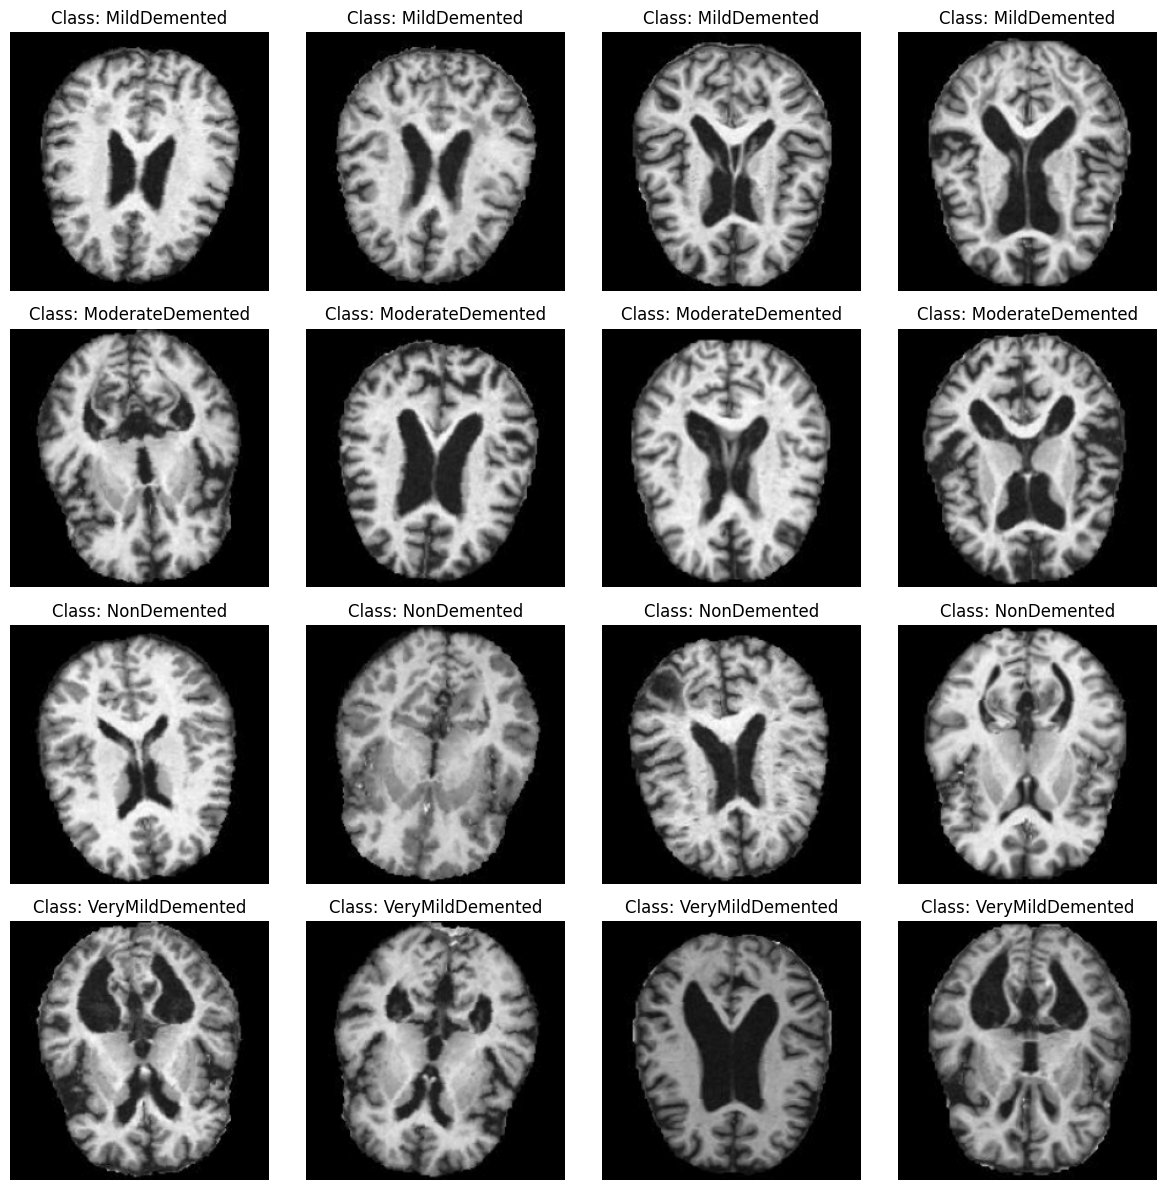

In [10]:
import random
from collections import defaultdict

classwise_samples = defaultdict(list)

for idx in range(len(dataset)):
    image, label = dataset[idx]
    classwise_samples[label].append(image)

num_classes = len(dataset.classes)
selected_images = []
selected_labels = []

for class_idx in range(num_classes):
    images = classwise_samples[class_idx]
    selected_images.extend(random.sample(images, min(4, len(images))))
    selected_labels.extend([class_idx] * min(4, len(images)))

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for idx, (image, label) in enumerate(zip(selected_images, selected_labels)):
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)

    axes[idx].imshow(image_np)
    axes[idx].axis("off")
    axes[idx].set_title(f"Class: {dataset.classes[label]}")

plt.tight_layout()
plt.show()

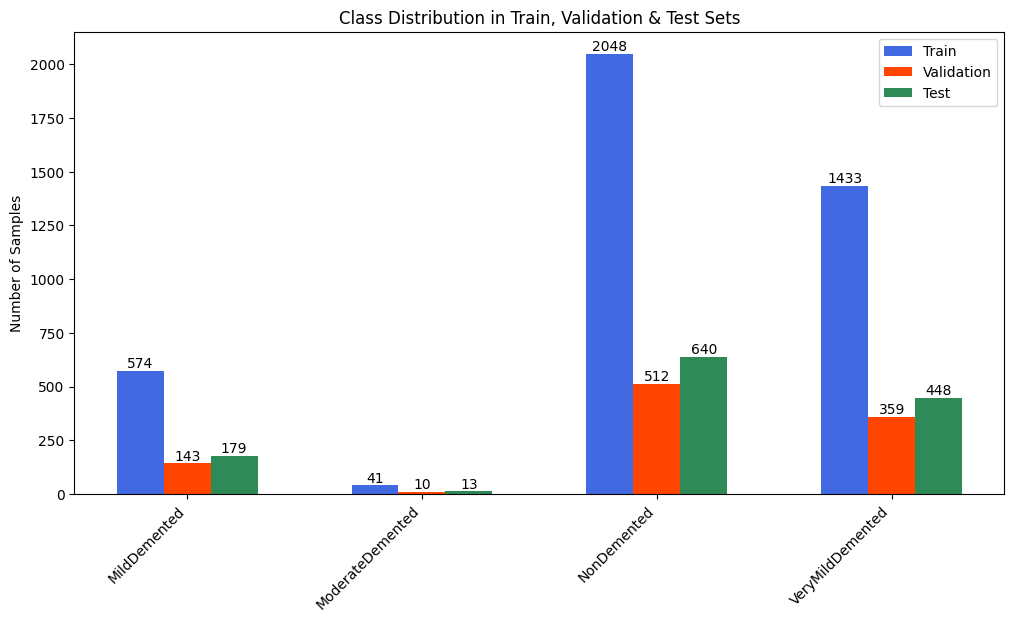

In [11]:
from collections import Counter

train_labels = [dataset.targets[idx] for idx in train_val_idx[train_idx]]
val_labels = [dataset.targets[idx] for idx in train_val_idx[val_idx]]
test_labels = [dataset.targets[idx] for idx in test_idx]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

classes = dataset.classes
x = np.arange(len(classes))

plt.figure(figsize=(12, 6))

train_bars = plt.bar(x - 0.2, [train_counts[i] for i in range(len(classes))], width=0.2, label="Train", color="royalblue")
val_bars = plt.bar(x, [val_counts[i] for i in range(len(classes))], width=0.2, label="Validation", color="orangered")
test_bars = plt.bar(x + 0.2, [test_counts[i] for i in range(len(classes))], width=0.2, label="Test", color="seagreen")

for bar in train_bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, color="black")

for bar in val_bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, color="black")

for bar in test_bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), 
             ha='center', va='bottom', fontsize=10, color="black")

plt.xticks(ticks=x, labels=classes, rotation=45, ha="right")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Train, Validation & Test Sets")
plt.legend()
plt.show()

### Channel-wise Block Attention Module

In [12]:
import torch.nn as nn
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import torch.nn.functional as F

In [13]:
class CBAM(torch.nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.max_pool = torch.nn.AdaptiveMaxPool2d(1)
        self.fc1 = torch.nn.Conv2d(channels, channels // reduction_ratio, kernel_size=1)
        self.fc2 = torch.nn.Conv2d(channels // reduction_ratio, channels, kernel_size=1)
        
        self.conv = torch.nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        
        avg_out = self.fc2(F.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(F.relu(self.fc1(self.max_pool(x))))
        channel_att = torch.sigmoid(avg_out + max_out)
        x = x * channel_att
        
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        
        return x * spatial_att

### Creating MobileNetV2-CBAM Model

In [14]:
from torchvision.models import MobileNet_V2_Weights
class MobileNetV2_Attention(torch.nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNetV2_Attention, self).__init__()
        self.mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        
        for name, module in self.mobilenet.features.named_children():
            if isinstance(module, torch.nn.Conv2d):
                channels = module.out_channels
                setattr(self.mobilenet.features, name, torch.nn.Sequential(module, CBAM(channels)))
        
        self.mobilenet.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.3),
            torch.nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        return self.mobilenet(x)

In [15]:
model = MobileNetV2_Attention(num_classes=4).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 122MB/s]


### Training Loop

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [17]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [18]:
early_stop_patience = 10
best_val_loss = float("inf")
early_stop_counter = 0

In [19]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50):
    global early_stop_counter, best_val_loss
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = evaluate_model(model, val_loader)
        
        train_losses.append(running_loss / total)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/total:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, LR: {optimizer.param_groups[0]['lr']}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{early_stop_patience}")

        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered! Training halted.")
            break

    return model

### Evaluation Loop

In [21]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.inference_mode():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total, running_loss / total

### Testing Loop with Metrics

In [22]:
def evaluate_model_with_metrics(model, loader, dataset):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print("Classification Report:\n", report)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

### Train, train, train

In [23]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler, epochs=50)

100%|██████████| 128/128 [00:17<00:00,  7.48it/s]


Epoch 1/50, Loss: 0.0316, Train Accuracy: 0.5376, Val Accuracy: 0.5908, LR: 0.0001


100%|██████████| 128/128 [00:15<00:00,  8.36it/s]


Epoch 2/50, Loss: 0.0286, Train Accuracy: 0.5613, Val Accuracy: 0.5430, LR: 0.0001
Early stopping counter: 1/10


100%|██████████| 128/128 [00:15<00:00,  8.26it/s]


Epoch 3/50, Loss: 0.0261, Train Accuracy: 0.5994, Val Accuracy: 0.5684, LR: 0.0001


100%|██████████| 128/128 [00:15<00:00,  8.09it/s]


Epoch 4/50, Loss: 0.0248, Train Accuracy: 0.6221, Val Accuracy: 0.6240, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.87it/s]


Epoch 5/50, Loss: 0.0243, Train Accuracy: 0.6372, Val Accuracy: 0.6230, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 6/50, Loss: 0.0221, Train Accuracy: 0.6721, Val Accuracy: 0.6602, LR: 0.0001


100%|██████████| 128/128 [00:17<00:00,  7.35it/s]


Epoch 7/50, Loss: 0.0208, Train Accuracy: 0.6941, Val Accuracy: 0.6367, LR: 0.0001
Early stopping counter: 1/10


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 8/50, Loss: 0.0185, Train Accuracy: 0.7410, Val Accuracy: 0.7393, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.73it/s]


Epoch 9/50, Loss: 0.0168, Train Accuracy: 0.7693, Val Accuracy: 0.7441, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 10/50, Loss: 0.0154, Train Accuracy: 0.7900, Val Accuracy: 0.7754, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.59it/s]


Epoch 11/50, Loss: 0.0132, Train Accuracy: 0.8298, Val Accuracy: 0.7422, LR: 0.0001
Early stopping counter: 1/10


100%|██████████| 128/128 [00:16<00:00,  7.64it/s]


Epoch 12/50, Loss: 0.0117, Train Accuracy: 0.8511, Val Accuracy: 0.8125, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 13/50, Loss: 0.0097, Train Accuracy: 0.8806, Val Accuracy: 0.8369, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.61it/s]


Epoch 14/50, Loss: 0.0083, Train Accuracy: 0.8967, Val Accuracy: 0.8496, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.63it/s]


Epoch 15/50, Loss: 0.0074, Train Accuracy: 0.9094, Val Accuracy: 0.8555, LR: 0.0001
Early stopping counter: 1/10


100%|██████████| 128/128 [00:16<00:00,  7.62it/s]


Epoch 16/50, Loss: 0.0068, Train Accuracy: 0.9207, Val Accuracy: 0.8506, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.64it/s]


Epoch 17/50, Loss: 0.0054, Train Accuracy: 0.9341, Val Accuracy: 0.8711, LR: 0.0001


100%|██████████| 128/128 [00:17<00:00,  7.11it/s]


Epoch 18/50, Loss: 0.0049, Train Accuracy: 0.9460, Val Accuracy: 0.8281, LR: 0.0001
Early stopping counter: 1/10


100%|██████████| 128/128 [00:16<00:00,  7.53it/s]


Epoch 19/50, Loss: 0.0048, Train Accuracy: 0.9443, Val Accuracy: 0.8857, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.60it/s]


Epoch 20/50, Loss: 0.0035, Train Accuracy: 0.9612, Val Accuracy: 0.8818, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.61it/s]


Epoch 21/50, Loss: 0.0034, Train Accuracy: 0.9614, Val Accuracy: 0.9150, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 22/50, Loss: 0.0034, Train Accuracy: 0.9604, Val Accuracy: 0.9092, LR: 0.0001
Early stopping counter: 1/10


100%|██████████| 128/128 [00:17<00:00,  7.48it/s]


Epoch 23/50, Loss: 0.0039, Train Accuracy: 0.9543, Val Accuracy: 0.9316, LR: 0.0001


100%|██████████| 128/128 [00:17<00:00,  7.53it/s]


Epoch 24/50, Loss: 0.0024, Train Accuracy: 0.9719, Val Accuracy: 0.9385, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.60it/s]


Epoch 25/50, Loss: 0.0028, Train Accuracy: 0.9692, Val Accuracy: 0.9150, LR: 0.0001
Early stopping counter: 1/10


100%|██████████| 128/128 [00:16<00:00,  7.55it/s]


Epoch 26/50, Loss: 0.0029, Train Accuracy: 0.9661, Val Accuracy: 0.9111, LR: 0.0001
Early stopping counter: 2/10


100%|██████████| 128/128 [00:16<00:00,  7.65it/s]


Epoch 27/50, Loss: 0.0019, Train Accuracy: 0.9795, Val Accuracy: 0.9346, LR: 0.0001
Early stopping counter: 3/10


100%|██████████| 128/128 [00:16<00:00,  7.57it/s]


Epoch 28/50, Loss: 0.0024, Train Accuracy: 0.9719, Val Accuracy: 0.8809, LR: 0.0001
Early stopping counter: 4/10


100%|██████████| 128/128 [00:16<00:00,  7.65it/s]


Epoch 29/50, Loss: 0.0018, Train Accuracy: 0.9817, Val Accuracy: 0.9443, LR: 0.0001


100%|██████████| 128/128 [00:16<00:00,  7.64it/s]


Epoch 30/50, Loss: 0.0021, Train Accuracy: 0.9744, Val Accuracy: 0.9287, LR: 0.0001
Early stopping counter: 1/10


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 31/50, Loss: 0.0014, Train Accuracy: 0.9839, Val Accuracy: 0.9297, LR: 0.0001
Early stopping counter: 2/10


100%|██████████| 128/128 [00:16<00:00,  7.67it/s]


Epoch 32/50, Loss: 0.0013, Train Accuracy: 0.9839, Val Accuracy: 0.9248, LR: 0.0001
Early stopping counter: 3/10


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 33/50, Loss: 0.0015, Train Accuracy: 0.9807, Val Accuracy: 0.9385, LR: 0.0001
Early stopping counter: 4/10


100%|██████████| 128/128 [00:17<00:00,  7.48it/s]


Epoch 34/50, Loss: 0.0015, Train Accuracy: 0.9827, Val Accuracy: 0.9336, LR: 0.0001
Early stopping counter: 5/10


100%|██████████| 128/128 [00:16<00:00,  7.64it/s]


Epoch 35/50, Loss: 0.0021, Train Accuracy: 0.9758, Val Accuracy: 0.9385, LR: 5e-05
Early stopping counter: 6/10


100%|██████████| 128/128 [00:16<00:00,  7.63it/s]


Epoch 36/50, Loss: 0.0006, Train Accuracy: 0.9932, Val Accuracy: 0.9482, LR: 5e-05
Early stopping counter: 7/10


100%|██████████| 128/128 [00:16<00:00,  7.60it/s]


Epoch 37/50, Loss: 0.0003, Train Accuracy: 0.9968, Val Accuracy: 0.9580, LR: 5e-05


100%|██████████| 128/128 [00:16<00:00,  7.65it/s]


Epoch 38/50, Loss: 0.0003, Train Accuracy: 0.9973, Val Accuracy: 0.9541, LR: 5e-05
Early stopping counter: 1/10


100%|██████████| 128/128 [00:16<00:00,  7.65it/s]


Epoch 39/50, Loss: 0.0004, Train Accuracy: 0.9961, Val Accuracy: 0.9502, LR: 5e-05
Early stopping counter: 2/10


100%|██████████| 128/128 [00:16<00:00,  7.67it/s]


Epoch 40/50, Loss: 0.0004, Train Accuracy: 0.9939, Val Accuracy: 0.9482, LR: 5e-05
Early stopping counter: 3/10


100%|██████████| 128/128 [00:16<00:00,  7.59it/s]


Epoch 41/50, Loss: 0.0004, Train Accuracy: 0.9954, Val Accuracy: 0.9600, LR: 5e-05
Early stopping counter: 4/10


100%|██████████| 128/128 [00:17<00:00,  7.50it/s]


Epoch 42/50, Loss: 0.0003, Train Accuracy: 0.9968, Val Accuracy: 0.9619, LR: 5e-05
Early stopping counter: 5/10


100%|██████████| 128/128 [00:18<00:00,  6.78it/s]


Epoch 43/50, Loss: 0.0006, Train Accuracy: 0.9934, Val Accuracy: 0.9502, LR: 2.5e-05
Early stopping counter: 6/10


100%|██████████| 128/128 [00:17<00:00,  7.18it/s]


Epoch 44/50, Loss: 0.0003, Train Accuracy: 0.9978, Val Accuracy: 0.9688, LR: 2.5e-05


100%|██████████| 128/128 [00:16<00:00,  7.57it/s]


Epoch 45/50, Loss: 0.0001, Train Accuracy: 0.9988, Val Accuracy: 0.9727, LR: 2.5e-05


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 46/50, Loss: 0.0001, Train Accuracy: 0.9985, Val Accuracy: 0.9453, LR: 2.5e-05
Early stopping counter: 1/10


100%|██████████| 128/128 [00:16<00:00,  7.67it/s]


Epoch 47/50, Loss: 0.0002, Train Accuracy: 0.9971, Val Accuracy: 0.9600, LR: 2.5e-05
Early stopping counter: 2/10


100%|██████████| 128/128 [00:16<00:00,  7.65it/s]


Epoch 48/50, Loss: 0.0001, Train Accuracy: 0.9995, Val Accuracy: 0.9619, LR: 2.5e-05
Early stopping counter: 3/10


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


Epoch 49/50, Loss: 0.0002, Train Accuracy: 0.9978, Val Accuracy: 0.9590, LR: 2.5e-05
Early stopping counter: 4/10


100%|██████████| 128/128 [00:16<00:00,  7.60it/s]


Epoch 50/50, Loss: 0.0001, Train Accuracy: 0.9998, Val Accuracy: 0.9658, LR: 2.5e-05
Early stopping counter: 5/10


### Loss and Accuracy Curves

In [24]:
def plot_metrics():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()

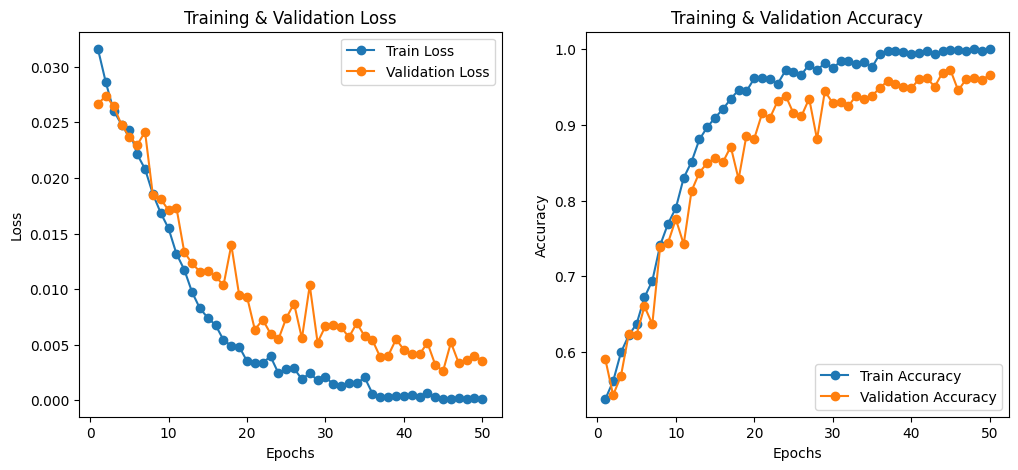

In [25]:
plot_metrics()

### Test, test, test

Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.93      0.98      0.96       179
ModerateDemented       1.00      1.00      1.00        13
     NonDemented       0.98      0.97      0.98       640
VeryMildDemented       0.97      0.96      0.96       448

        accuracy                           0.97      1280
       macro avg       0.97      0.98      0.97      1280
    weighted avg       0.97      0.97      0.97      1280



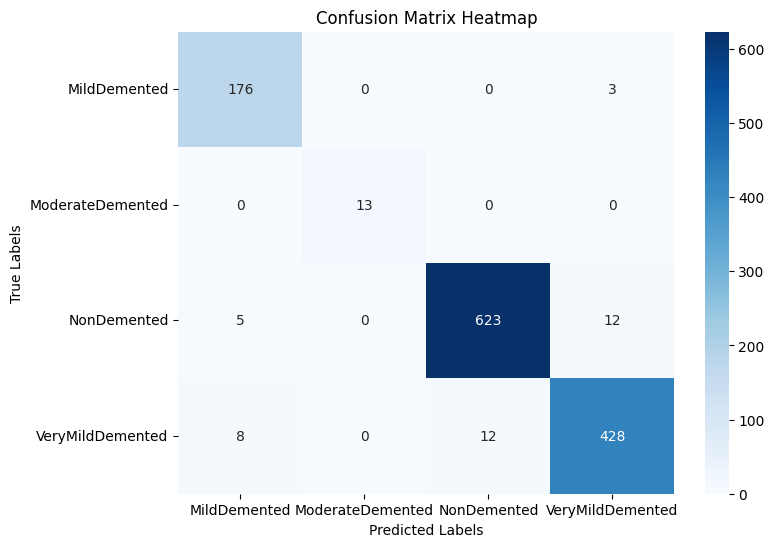

In [26]:
evaluate_model_with_metrics(trained_model, test_loader, dataset)

In [27]:
torch.save(trained_model.state_dict(), "trained_mobilenetv2_cbam.pth")

### Grad-CAM and LIME Explainability of MobileNetV2 + CBAM

In [31]:
trained_model = MobileNetV2_Attention(num_classes=4).to(device)
trained_model.load_state_dict(torch.load("trained_mobilenetv2_cbam.pth", map_location=device))
trained_model.eval()
print("Model loaded successfully!")

Model loaded successfully!


### Grad-CAM

In [32]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None  
        
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()

        output[:, target_class].backward()
        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()
        
        weights = np.mean(gradients, axis=(2, 3))
        cam = np.sum(weights[:, :, None, None] * activations, axis=1)
        cam = np.maximum(cam, 0)  
        cam -= cam.min()
        cam /= cam.max()

        return cv2.resize(cam[0], (input_tensor.shape[-1], input_tensor.shape[-2]))

target_layer = model.mobilenet.features[-3]
grad_cam = GradCAM(model, target_layer)

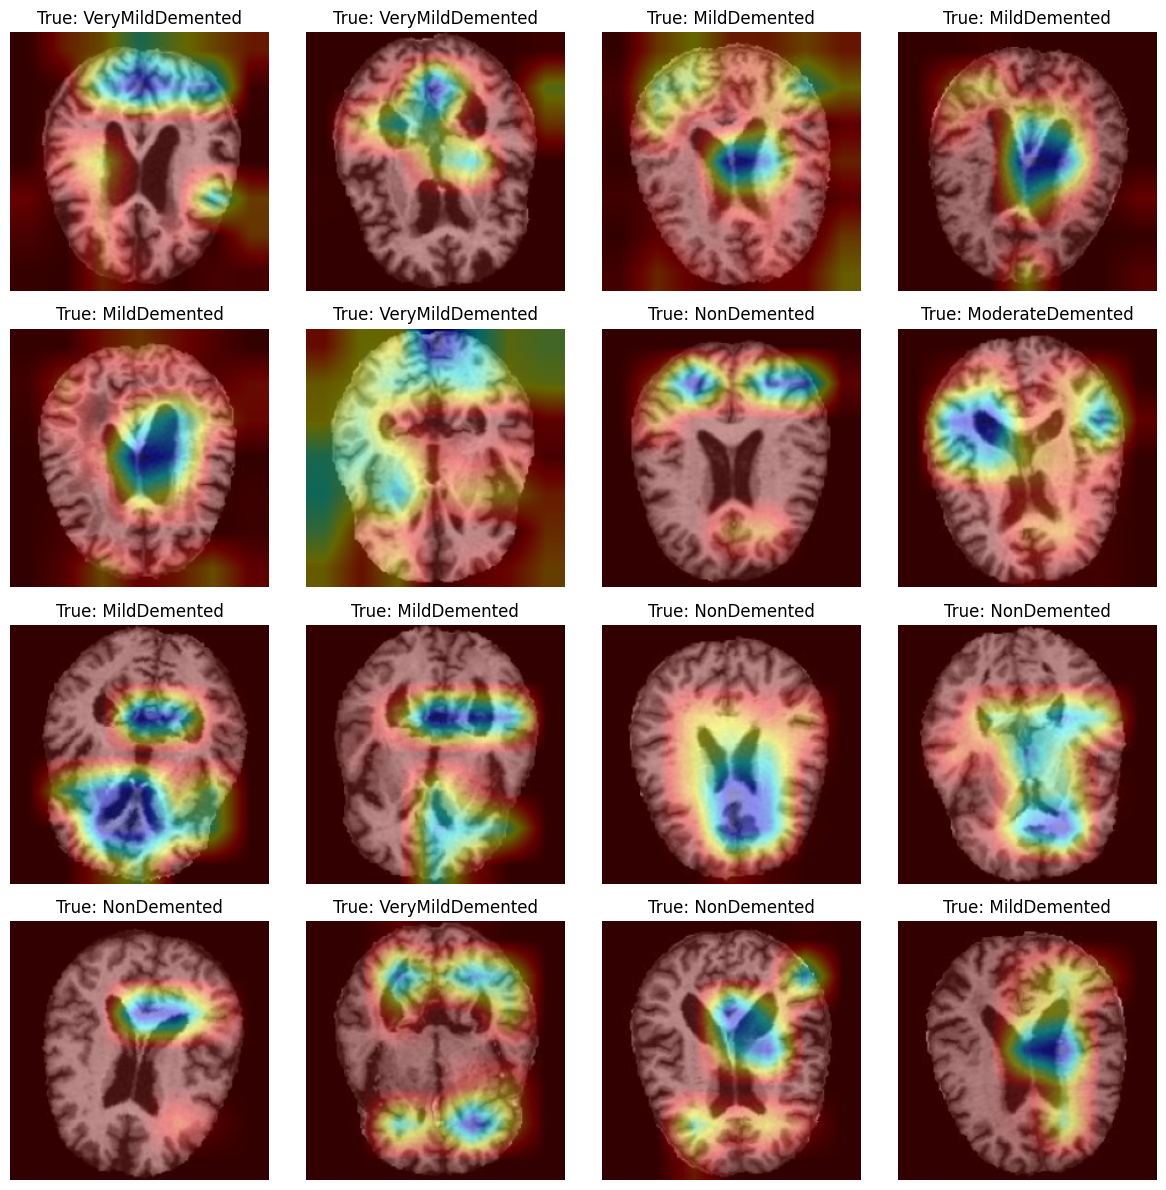

In [35]:
import cv2

num_images = 16

test_images, test_labels = next(iter(test_loader))
test_images = test_images[:num_images].to(device)
test_labels = test_labels[:num_images].to(device)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for idx, image in enumerate(test_images):
    input_tensor = image.unsqueeze(0)
    target_class = torch.argmax(model(input_tensor))
    heatmap = grad_cam.generate_heatmap(input_tensor, target_class.item())
    
    image_np = image.permute(1, 2, 0).cpu().numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = ((image_np * std) + mean) * 255
    image_np = np.clip(image_np, 0, 255).astype(np.uint8)
    
    heatmap_overlay = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    overlayed_image = cv2.addWeighted(image_np, 0.6, heatmap_overlay, 0.4, 0)
    
    axes[idx].imshow(overlayed_image)
    axes[idx].axis("off")
    axes[idx].set_title(f"True: {dataset.classes[test_labels[idx].item()]}")

plt.tight_layout()
plt.show()

### LIME

In [38]:
import lime
import lime.lime_image
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

In [39]:
explainer = lime.lime_image.LimeImageExplainer()

In [40]:
def predict_fn(images):
    images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)
    outputs = model(images)
    return torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

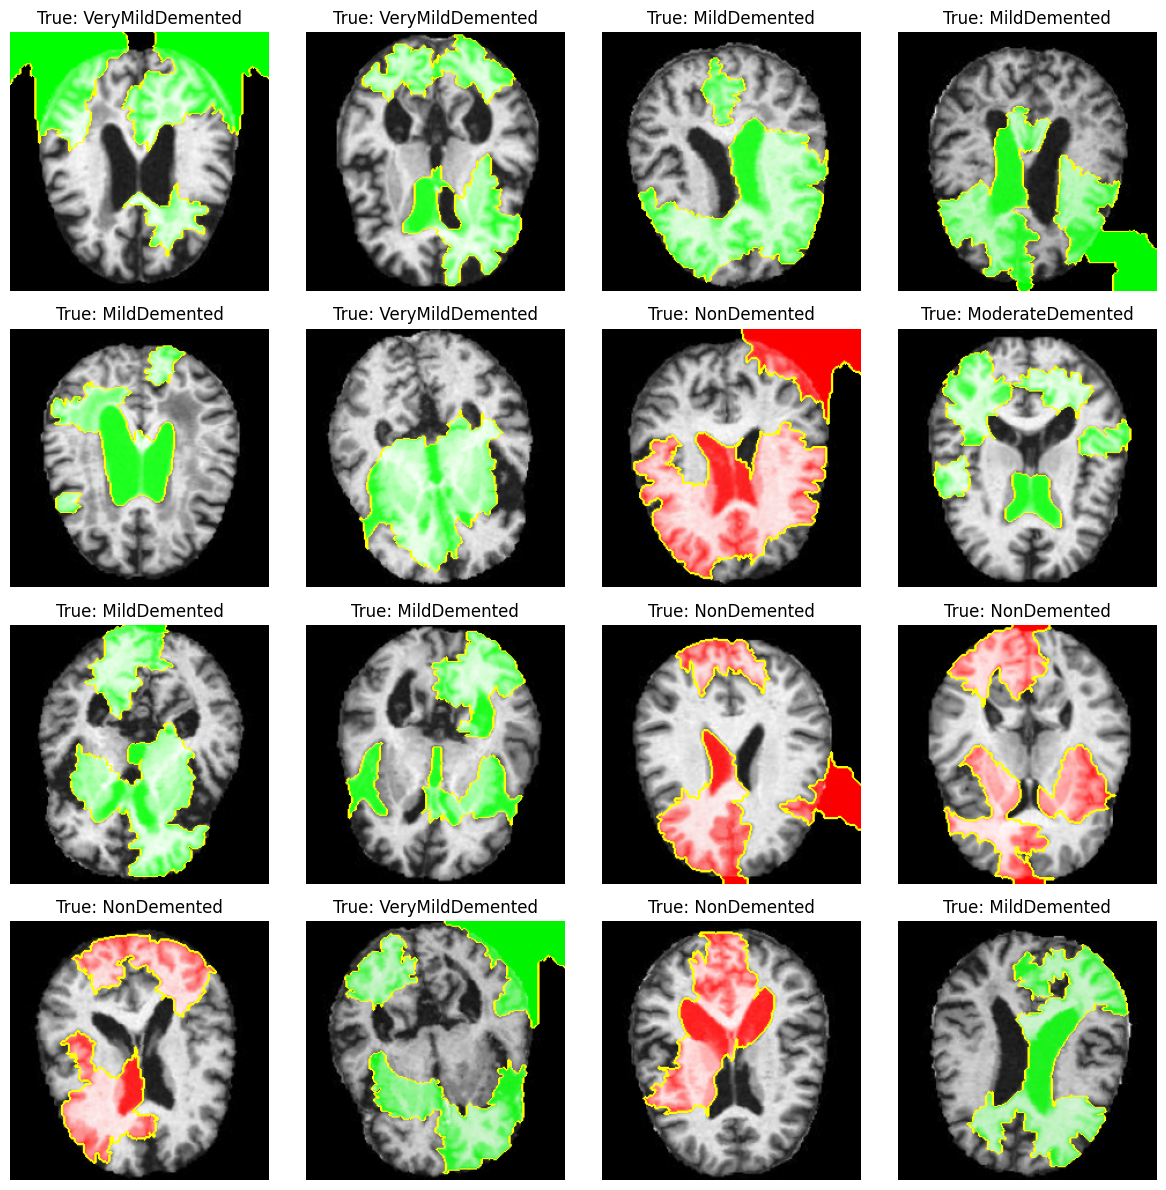

In [41]:
num_images = 16

test_images, test_labels = next(iter(test_loader))
test_images = test_images[:num_images]
test_labels = test_labels[:num_images]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for idx, image in enumerate(test_images):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = ((image_np * std) + mean)
    
    explanation = explainer.explain_instance(image_np, predict_fn, labels=(0, 1, 2, 3), hide_color=0, num_samples=1000)
    
    target_class = torch.argmax(model(image.unsqueeze(0).to(device))).item()
    temp, mask = explanation.get_image_and_mask(target_class, positive_only=False, hide_rest=False)
    
    axes[idx].imshow(mark_boundaries(temp, mask))
    axes[idx].axis("off")
    axes[idx].set_title(f"True: {dataset.classes[test_labels[idx].item()]}")

plt.tight_layout()
plt.show()

## Feature Extraction Using Trained Model

### Importing Libraries and Loading Dataset

In [43]:
import torch
import pandas as pd
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import torch.nn as nn

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [46]:
data_dir = '/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

### MobileNetV2-CBAM Model Creation and Loading with Training Weights and Biases

In [47]:
data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

In [48]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv2d(channels // reduction_ratio, channels, kernel_size=1)
        
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        
        avg_out = self.fc2(nn.ReLU()(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(nn.ReLU()(self.fc1(self.max_pool(x))))
        channel_att = torch.sigmoid(avg_out + max_out)
        x = x * channel_att
        
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        
        return x * spatial_att

In [49]:
class MobileNetV2_CBAM(nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNetV2_CBAM, self).__init__()
        self.mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        
        for name, module in self.mobilenet.features.named_children():
            if isinstance(module, nn.Conv2d):
                channels = module.out_channels
                setattr(self.mobilenet.features, name, nn.Sequential(module, CBAM(channels)))
                
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        return self.mobilenet(x)

In [50]:
mobilenet_cbam = MobileNetV2_CBAM(num_classes=4)
mobilenet_cbam.load_state_dict(torch.load("/kaggle/working/trained_mobilenetv2_cbam.pth", map_location=device))

<All keys matched successfully>

In [51]:
mobilenet_cbam.mobilenet.classifier = nn.Identity()

### Let's extract some features, eh?

In [52]:
mobilenet_cbam.to(device)
mobilenet_cbam.eval()

features_list = []
labels_list = []

with torch.inference_mode():
    for images, labels in tqdm(data_loader):
        images = images.to(device)

        feature_vectors = mobilenet_cbam(images)
        features_list.extend(feature_vectors.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

features_df = pd.DataFrame(features_list)
features_df['label'] = labels_list

100%|██████████| 200/200 [00:13<00:00, 14.86it/s]


### Saving extracted features to .csv format

In [53]:
features_df.to_csv("/kaggle/working/trained_mobilenet_cbam_features.csv", index=False)
print("Feature extraction complete! Saved as trained_mobilenet_cbam_features.csv")

Feature extraction complete! Saved as trained_mobilenet_cbam_features.csv


## Feature Selection + Machine Learning Classification

### Import Necessary Libraries

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

print('Modules loaded')

Modules loaded


### Load Dataset

In [12]:
df = pd.read_csv('/kaggle/working/trained_mobilenet_cbam_features.csv')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df_shuffled = shuffle(df, random_state=42)

train_df = df_shuffled.groupby('label', group_keys=False, as_index=False).apply(lambda x: x.sample(frac=0.8, random_state=42))
test_df = df_shuffled.drop(train_df.index)

X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test, y_test = test_df.drop(columns=['label']), test_df['label']

print('Dataset Loaded')

Dataset Loaded


/tmp/ipykernel_35/1430856412.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df_shuffled.groupby('label', group_keys=False, as_index=False).apply(lambda x: x.sample(frac=0.8, random_state=42))


### Renyi-entropy based Feature Selection Algorithm

In [13]:
def renyi_entropy(feature_values, alpha=2):
    """Compute Rényi entropy for a single feature."""
    probabilities, counts = np.unique(feature_values, return_counts=True)
    probabilities = counts / counts.sum()

    if alpha == 1:
        return -np.sum(probabilities * np.log(probabilities + 1e-9))
    else:
        return 1 / (1 - alpha) * np.log(np.sum(probabilities ** alpha))

In [14]:
# Compute Rényi entropy for all features
feature_entropies = {feature: renyi_entropy(X_train[feature].values, alpha=2) for feature in X_train.columns}

# Sort features by entropy (highest entropy = most informative)
sorted_features = sorted(feature_entropies, key=feature_entropies.get, reverse=True)

# Select Top K Features
top_features = sorted_features[:240]

X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print('Top K-features Selected')

Top K-features Selected


In [15]:
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

### ML - Voting Ensemble of Logistic Regression, Support Vector Machine, and Random Forest

In [16]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', solver='saga', max_iter=3000)),
        ('svm', SVC(class_weight='balanced', probability=True)),
        ('rf', RandomForestClassifier(class_weight='balanced'))
    ],
    voting='soft'
)

voting_clf.fit(X_train_selected, y_train)
y_pred_voting = voting_clf.predict(X_test_selected)

print('Model Training and Inference Done')

Model Training and Inference Done


### Classification Report and Confusion Matrix Heatmap

Voting Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       179
           1       1.00      1.00      1.00        13
           2       0.99      0.99      0.99       640
           3       1.00      0.99      0.99       448

    accuracy                           0.99      1280
   macro avg       0.99      1.00      1.00      1280
weighted avg       0.99      0.99      0.99      1280



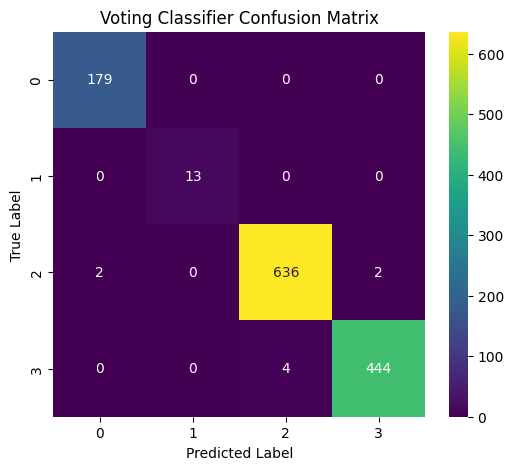

In [17]:
print("Voting Classifier Classification Report:\n", classification_report(y_test, y_pred_voting))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot=True, cmap='viridis', fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Voting Classifier Confusion Matrix")
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_voting)
precision = precision_score(y_test, y_pred_voting, average='weighted')
recall = recall_score(y_test, y_pred_voting, average='weighted')
f1 = f1_score(y_test, y_pred_voting, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

Accuracy: 0.9938
Precision (Weighted): 0.9938
Recall (Weighted): 0.9938
F1 Score (Weighted): 0.9937


### Number of Features Selected versus Accuracy

Features: 100, Accuracy: 99.14%
Features: 120, Accuracy: 99.22%
Features: 140, Accuracy: 99.22%
Features: 160, Accuracy: 99.30%
Features: 180, Accuracy: 99.22%
Features: 200, Accuracy: 99.22%
Features: 220, Accuracy: 99.22%
Features: 240, Accuracy: 99.38%
Features: 260, Accuracy: 99.38%
Features: 280, Accuracy: 99.38%
Features: 300, Accuracy: 99.38%


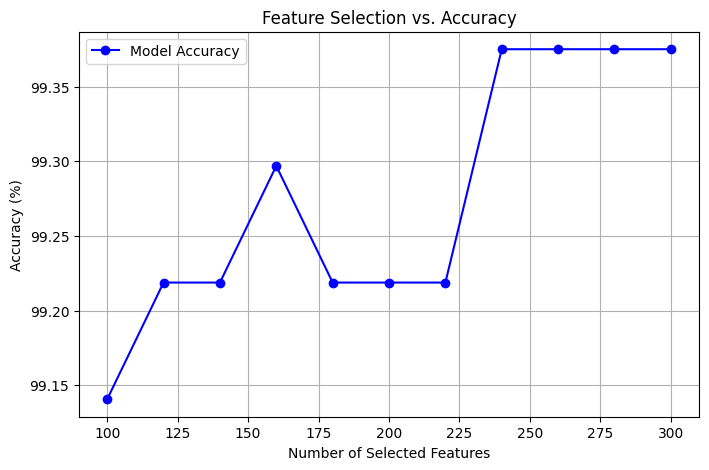

In [10]:
import matplotlib.pyplot as plt

feature_counts = [100, 120, 140, 160, 180,
                  200, 220, 240, 260, 280, 300]
accuracies = []

for num_features in feature_counts:
    
    top_features = sorted_features[:num_features]
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]
    
    scaler = StandardScaler()
    X_train_selected = scaler.fit_transform(X_train_selected)
    X_test_selected = scaler.transform(X_test_selected)
    
    voting_clf.fit(X_train_selected, y_train)
    y_pred_voting = voting_clf.predict(X_test_selected)
    
    accuracy = voting_clf.score(X_test_selected, y_test) * 100
    accuracies.append(accuracy)
    print(f"Features: {num_features}, Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(feature_counts, accuracies, marker='o', linestyle='-', color='b', label="Model Accuracy")
plt.xlabel("Number of Selected Features")
plt.ylabel("Accuracy (%)")
plt.title("Feature Selection vs. Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Stratified 5-fold Cross Validation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle

df = pd.read_csv('/kaggle/working/trained_mobilenet_cbam_features.csv')

In [2]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df_shuffled = shuffle(df, random_state=42)

X, y = df_shuffled.drop(columns=['label']), df_shuffled['label']

In [3]:
def renyi_entropy(feature_values, alpha=2):
    """Compute Rényi entropy for a single feature."""
    probabilities, counts = np.unique(feature_values, return_counts=True)
    probabilities = counts / counts.sum()
    
    if alpha == 1:
        return -np.sum(probabilities * np.log(probabilities + 1e-9))
    else:
        return 1 / (1 - alpha) * np.log(np.sum(probabilities ** alpha))

feature_entropies = {feature: renyi_entropy(X[feature].values, alpha=2) for feature in X.columns}

sorted_features = sorted(feature_entropies, key=feature_entropies.get, reverse=True)

top_features = sorted_features[:240]

X_selected = X[top_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

         accuracy  precision  recall  f1-score
Average     0.992      0.992   0.992     0.992


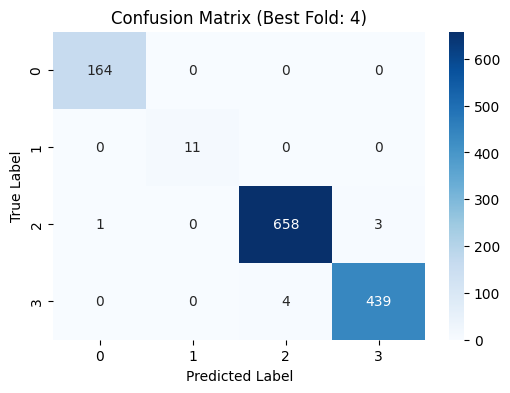

Classification Report (Best Fold: 4):

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       164
           1       1.00      1.00      1.00        11
           2       0.99      0.99      0.99       662
           3       0.99      0.99      0.99       443

    accuracy                           0.99      1280
   macro avg       1.00      1.00      1.00      1280
weighted avg       0.99      0.99      0.99      1280



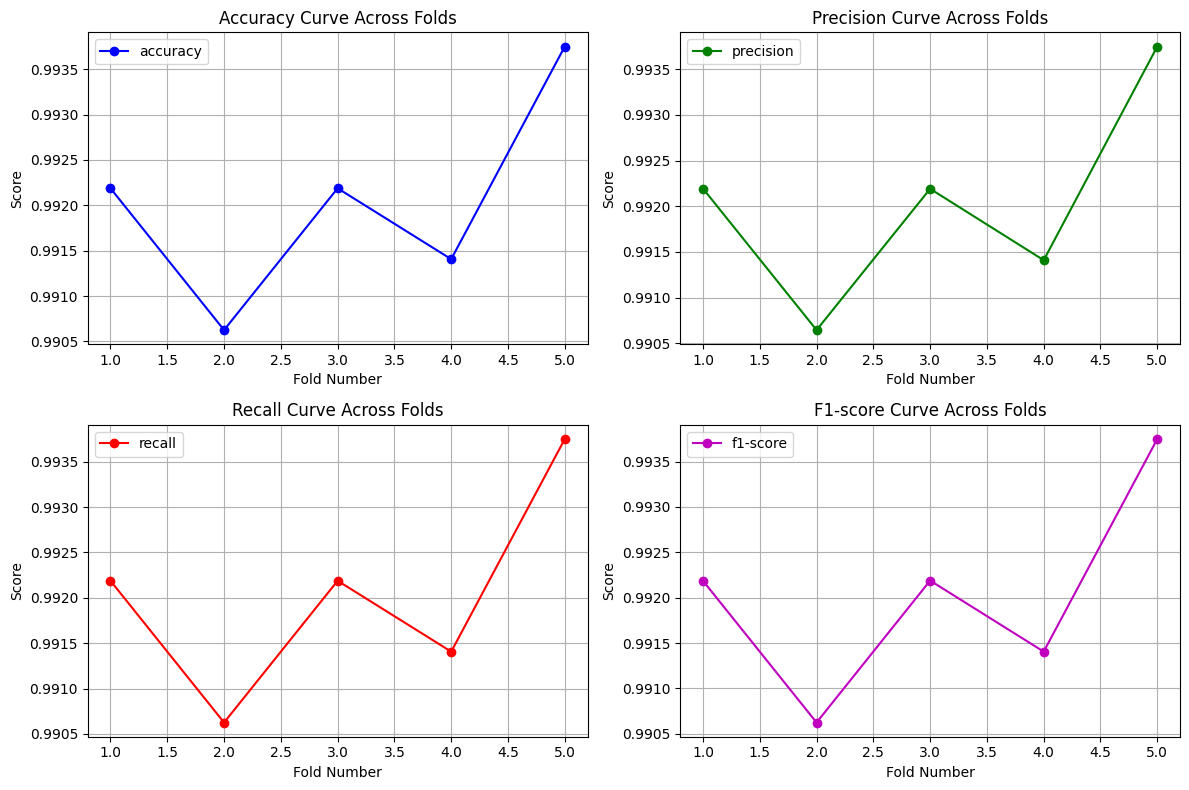

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1-score': []}
best_fold = {'index': None, 'accuracy': 0, 'y_true': None, 'y_pred': None}

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', solver='saga', max_iter=3000)),
        ('svm', SVC(class_weight='balanced', probability=True)),
        ('rf', RandomForestClassifier(class_weight='balanced'))
    ],
    voting='soft'
)

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1-score'].append(f1)
    
    if acc > best_fold['accuracy']:
        best_fold.update({'index': fold, 'accuracy': acc, 'y_true': y_test, 'y_pred': y_pred})

average_metrics = {key: np.mean(values) for key, values in metrics.items()}
print(pd.DataFrame(average_metrics, index=['Average']).round(4))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(best_fold['y_true'], best_fold['y_pred']), annot=True, cmap='Blues', fmt='d')
plt.title(f"Confusion Matrix (Best Fold: {best_fold['index']})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(f"Classification Report (Best Fold: {best_fold['index']}):\n")
print(classification_report(best_fold['y_true'], best_fold['y_pred']))

plt.figure(figsize=(12, 8))

metrics_list = ['accuracy', 'precision', 'recall', 'f1-score']
colors = ['b', 'g', 'r', 'm']

for i, metric in enumerate(metrics_list):
    plt.subplot(2, 2, i+1)
    plt.plot(range(1, 6), metrics[metric], marker='o', color=colors[i], label=metric)
    plt.title(f"{metric.capitalize()} Curve Across Folds")
    plt.xlabel("Fold Number")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

### SHAP Analysis

Modules loaded


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Dataset Loaded
Top K-features Selected
Model Training and Inference Done
Voting Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       179
           1       1.00      1.00      1.00        13
           2       0.99      0.99      0.99       640
           3       0.99      0.99      0.99       448

    accuracy                           0.99      1280
   macro avg       0.99      1.00      0.99      1280
weighted avg       0.99      0.99      0.99      1280



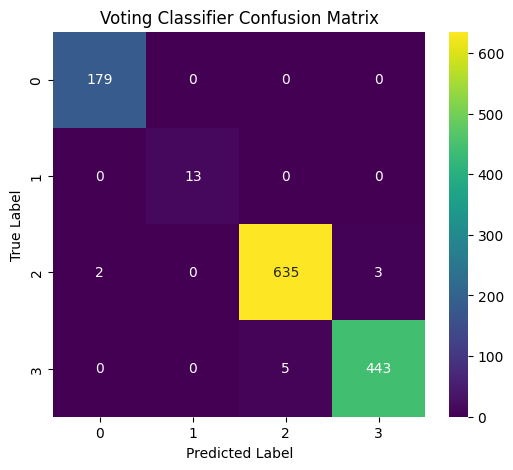

Applying SHAP KernelExplainer...


  0%|          | 0/25 [00:00<?, ?it/s]

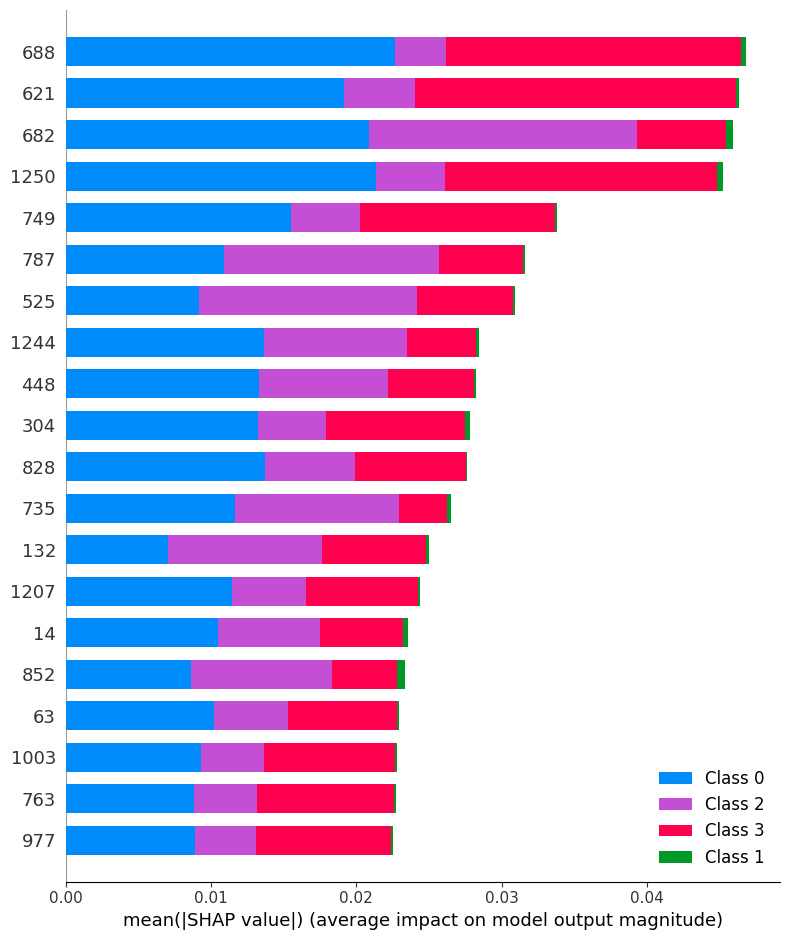

SHAP analysis completed!


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

print('Modules loaded')

df = pd.read_csv('/kaggle/working/trained_mobilenet_cbam_features.csv')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

df_shuffled = shuffle(df, random_state=42)

train_df = df_shuffled.groupby('label', group_keys=False, as_index=False).apply(lambda x: x.sample(frac=0.8, random_state=42))
test_df = df_shuffled.drop(train_df.index)

X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test, y_test = test_df.drop(columns=['label']), test_df['label']

print('Dataset Loaded')

def renyi_entropy(feature_values, alpha=2):
    """Compute Rényi entropy for a single feature."""
    probabilities, counts = np.unique(feature_values, return_counts=True)
    probabilities = counts / counts.sum()

    if alpha == 1:
        return -np.sum(probabilities * np.log(probabilities + 1e-9))
    else:
        return 1 / (1 - alpha) * np.log(np.sum(probabilities ** alpha))

feature_entropies = {feature: renyi_entropy(X_train[feature].values, alpha=2) for feature in X_train.columns}
sorted_features = sorted(feature_entropies, key=feature_entropies.get, reverse=True)
top_features = sorted_features[:240]

X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print('Top K-features Selected')

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', solver='saga', max_iter=3000)),
        ('svm', SVC(class_weight='balanced', probability=True)),
        ('rf', RandomForestClassifier(class_weight='balanced'))
    ],
    voting='soft'
)

voting_clf.fit(X_train_selected, y_train)
y_pred_voting = voting_clf.predict(X_test_selected)

print('Model Training and Inference Done')

print("Voting Classifier Classification Report:\n", classification_report(y_test, y_pred_voting))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot=True, cmap='viridis', fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Voting Classifier Confusion Matrix")
plt.show()

print("Applying SHAP KernelExplainer...")

explainer = shap.KernelExplainer(voting_clf.predict_proba, X_train_selected[:25])

shap_values = explainer.shap_values(X_test_selected[:25])

shap.summary_plot(shap_values, X_test_selected[:25], feature_names=top_features)

print("SHAP analysis completed!")